In [2]:
# Import Libraries
import os
import psutil
import time

import cudf
import pandas as pd
from datetime import datetime

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Metadata and Climate Data from GHCND
metadata = pd.read_fwf('https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt', header= None)
metadata.columns = ['station_id', 'latitude', 'longitude', 'elevation', 'name', 'hcn_crn_flag', 'gsn_flag', 'wmo_id']
metadata = metadata[['station_id', 'latitude', 'longitude', 'elevation', 'name']]
metadata = cudf.DataFrame(metadata)

In [4]:
temp_data = cudf.read_csv('/datasets/weather_decomp/2000.csv',header=None) #Downloaded from https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/
temp_data.columns = ['station_id', 'date', 'type', 'value', 'mflag', 'qflag', 'sflag', 'unique_id']

In [5]:
req_cols = ['station_id', 'latitude', 'longitude', 'elevation', 'date', 'name', 'type', 'sflag', 'value']
data = cudf.merge(temp_data, metadata, on='station_id', how='left')
del temp_data
del metadata
data = data[req_cols]
data.dropna(inplace=True)

In [6]:
# Pre-processing
dates = cudf.to_datetime(data['date'].astype(str), format='%Y%m%d')
dates = cudf.DatetimeIndex(dates)
data['month'] = dates.month
data['day'] = dates.day

# Extract country code
data['country_code'] = data['station_id'].astype(str).str[:2]

In [7]:
features = ['country_code', 'sflag', 'month', 'type', 'day', 'latitude', 'longitude', 'elevation']
target = 'value'

In [8]:
data['country_code'] = data['country_code'].astype('category')
data['month'] = data['month'].astype('category')
data['day'] = data['day'].astype('category')
data['type'] = data['type'].astype('category')
data['sflag'] = data['sflag'].astype('category')

In [9]:
# Train the model
model_params = {'objective': 'reg:linear', 
                'learning_rate': 0.1, 
                'colsample_bytree' : 0.3, 
                'max_depth': 5, 
                'n_estimators':10, 
                'alpha' : 10, 
                'silent': True, 
                'verbose_eval': True, 
                'tree_method':'gpu_hist'}

# Create train and test dmatrix
dtrain = xgb.DMatrix(data[features], data[target], enable_categorical=True)

boost_rounds = [50, 100, 200, 350, 500]

latency_dict ={key: list() for key in ['time', 'iterations', 'memory']}

for k in boost_rounds:
    model_params['n_estimators'] = k
    t = time.time()

    trained_model = xgb.train(model_params, dtrain, num_boost_round=k )   #, evals=[(dtrain, 'train')]
    latency_dict['time'].append(time.time()-t)
    latency_dict['iterations'].append(k)
    latency_dict['memory'].append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)

    del trained_model

[22:43:24] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:24] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators", "silent", "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:43:30] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:30] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators", "silent", "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find an

In [10]:
latency_dict

{'time': [6.1391847133636475,
  9.757361888885498,
  19.496212482452393,
  33.870954751968384,
  48.16785383224487],
 'iterations': [50, 100, 200, 350, 500],
 'memory': [1829.3203125, 1829.4140625, 1829.4296875, 1829.4375, 1832.4140625]}

## Light Gradient Boost

In [11]:
model_params = {'objective':'regression',
                 'learning_rate': 0.1, 
                 'feature_fraction': 0.3, 
                 'max_depth': 5, 
                 'verbose': -1, 
                 'n_estimators':10, 
                 'device': 'gpu', 
                 'gpu_platform_id':'3', 
                 'gpu_device_id':'3'
                 }

In [12]:
# Training

lgb_train = lgb.Dataset(data[features].to_pandas(), data[target].to_pandas())

lgb_latency_dict ={key: list() for key in ['time','iterations','memory']}

for k in boost_rounds:
    model_params['n_estimators'] = k
    t = time.time()

    trained_model = lgb.train(model_params, lgb_train, num_boost_round = k)   #, evals=[(dtrain, 'train')]
    lgb_latency_dict['time'].append(time.time()-t)
    lgb_latency_dict['iterations'].append(k)
    lgb_latency_dict['memory'].append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)

    del trained_model

In [13]:
lgb_latency_dict

{'time': [19.352845907211304,
  29.407073736190796,
  57.138556718826294,
  94.49023842811584,
  133.39979147911072],
 'iterations': [50, 100, 200, 350, 500],
 'memory': [2362.890625, 2365.40234375, 2367.90234375, 2370.609375, 2371.9375]}

In [16]:
latency_dict['model'] = ['XGB']*5
lgb_latency_dict['model'] = ['LGBM']*5

In [27]:
results = pd.concat([pd.DataFrame(latency_dict), pd.DataFrame(lgb_latency_dict)])
results.reset_index(drop=True, inplace=True)
results.columns = ['Time', 'Boosting_rounds', 'Memory', 'Model']

Text(0.5, 1.0, 'Time taken by XGBoost & LightGBM w.r.t # boosting rounds')

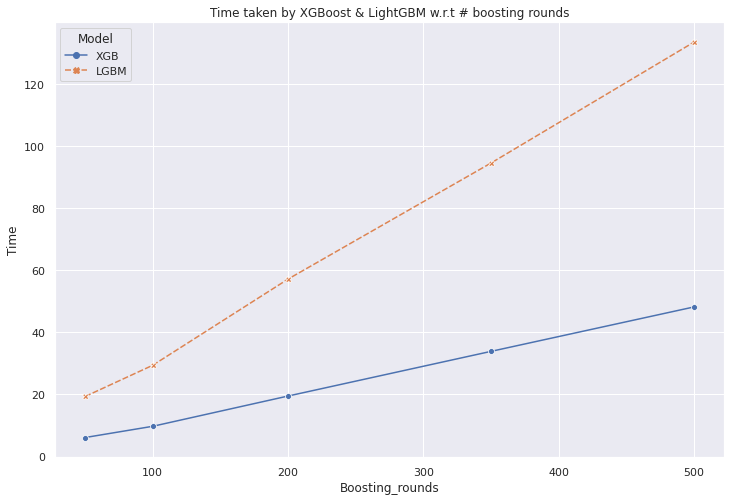

In [49]:
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(data=results, x='Boosting_rounds', y='Time', hue='Model',style='Model', markers=True).set_title('Time taken by XGBoost & LightGBM w.r.t # boosting rounds')

In [50]:
!nvidia-smi

Wed Jul 27 23:11:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:3B:00.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |   7759MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:5E:00.0 Off |                    0 |
| N/A   